In [29]:
import os
import re
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# Loading Data

In [18]:
def parse_input(x):
    if os.path.exists("/users/vspvikram/Downloads/ecgen-radiology/%s.xml" %x):
        f = open("/users/vspvikram/Downloads/ecgen-radiology/%s.xml" %x, 'r')
        soup = BeautifulSoup(f, "html.parser")
        reports = soup.find(label="IMPRESSION").get_text().lower()
        return re.sub(r'[\W]', ' ', reports)
    
image = pd.Series(os.listdir('/users/vspvikram/Downloads/NLMCXR_png'))
number = image.apply(lambda x: x.split('_')[0][3:])
report = number.apply(parse_input)

In [23]:
df = pd.DataFrame({'Image': image, 'Number': number, 'Caption': report}).dropna().sort_values(['Number']).reset_index(drop
                                                                                                                     =True)
df.head()

,Image,Number,Caption
0,CXR1_1_IM-0001-4001.png,1,normal chest x xxxx
1,CXR1_1_IM-0001-3001.png,1,normal chest x xxxx
2,CXR10_IM-0002-2001.png,10,no acute cardiopulmonary process
3,CXR10_IM-0002-1001.png,10,no acute cardiopulmonary process
4,CXR100_IM-0002-2001.png,100,no active disease


# Sample Images and report

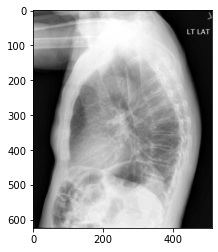

no acute cardiopulmonary process 



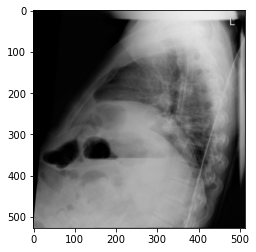

1  probable xxxx residual left pneumothorax  2  stable streaky left basilar airspace disease  possibly atelectasis 



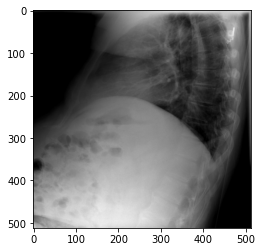

low lung volumes  otherwise  no definite acute findings 



In [25]:
for i in range(3):
    file_name = np.random.choice(df.Image)
    img = Image.open('/users/vspvikram/Downloads/NLMCXR_png/' + file_name)
    plt.imshow(img)
    plt.show()
    print(df[df.Image == file_name].Caption.item())
    print()

# Visualization

In [32]:
texts = df.Caption.unique()
texts = functools.reduce(lambda a, b: a + b, texts).split()
texts = [i for i in texts if i not in set(stopwords.words('english'))]
words_counter = Counter(texts)

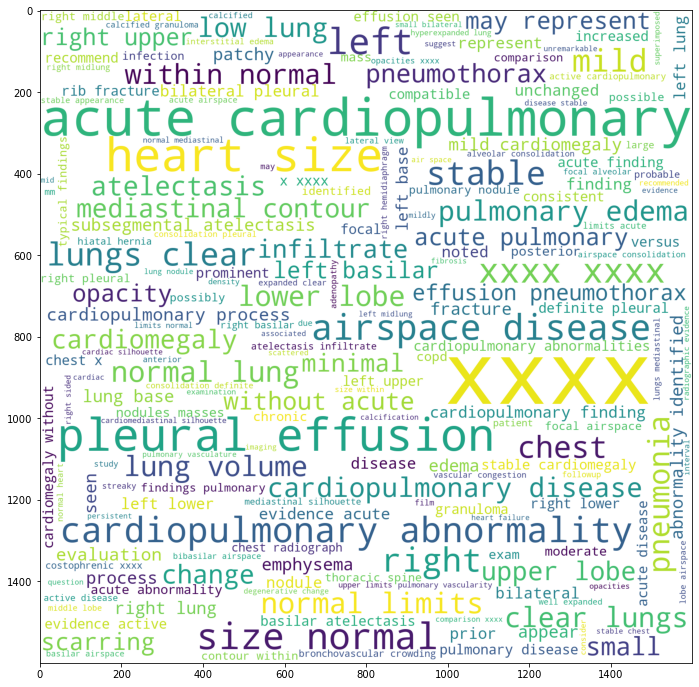

In [33]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(
    width=1600, height=1600,
    background_color = 'white',
    min_font_size=10).generate(" ".join(texts))

plt.imshow(wordcloud)
plt.show()

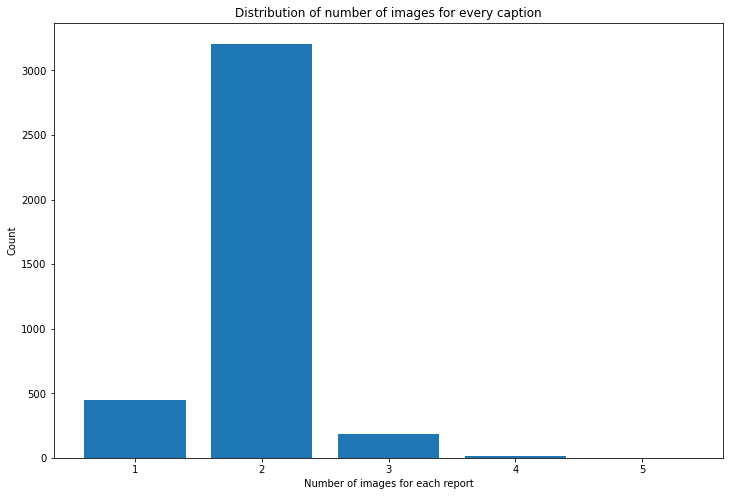

In [39]:
n_img = df.groupby(['Number']).size().value_counts().reset_index()
n_img.columns = ['Number of images', 'Count']

plt.figure(figsize=(12,8))
plt.bar(x=n_img['Number of images'], height=n_img['Count'])
plt.xlabel("Number of images for each report")
plt.ylabel("Count")
plt.title("Distribution of number of images for every caption")
plt.show()

In [145]:
df2 = df.copy()
df2['Img_count'] = df['Image'].groupby(df['Number']).transform('count')

# keeping only the 2 images per report files
df2 = df2[df2.Img_count == 2] 

Image_names = df2.groupby(['Number']).apply(lambda x: ', '.join(x.Image)).reset_index()
Image_names.rename(columns= {'Number': 'Number', 0: 'Image'})
df2 = df2[['Number', 'Caption']]
df2 = df2.drop_duplicates()
df2 = df2.merge(Image_names, on='Number')

df2.rename(columns={0: 'Images'}, inplace=True)
Images = df2['Images'].str.split(',', n=1, expand=True)
df2['Image1'] = Images[0]
df2['Image2'] = Images[1]
df2.drop(columns=['Images'], inplace=True)
df2

,Number,Caption,Image1,Image2
0,1,normal chest x xxxx,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png
1,10,no acute cardiopulmonary process,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png
2,100,no active disease,CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png
3,1001,diffuse fibrosis no visible focal acute disease,CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png
4,1002,status post left mastectomy heart size normal...,CXR1002_IM-0004-2001.png,CXR1002_IM-0004-1001.png
...,...,...,...,...
3203,994,negative chest,CXR994_IM-2478-2001.png,CXR994_IM-2478-1001.png
3204,995,post operative chest with no acute disease,CXR995_IM-2478-1002.png,CXR995_IM-2478-1001.png
3205,996,heart size is normal and lungs are clear no p...,CXR996_IM-2479-1001.png,CXR996_IM-2479-2001.png
3206,997,no acute cardiopulmonary abnormality,CXR997_IM-2479-1001.png,CXR997_IM-2479-2001.png


In [172]:
df2['Caption'].value_counts()[:20]

no acute cardiopulmonary abnormality                 265
no active disease                                    102
no acute cardiopulmonary abnormalities                97
no acute cardiopulmonary findings                     96
no acute disease                                      92
no acute cardiopulmonary disease                      77
no acute cardiopulmonary process                      56
1  no acute radiographic cardiopulmonary process      49
no evidence of active disease                         41
no acute pulmonary disease                            39
1  no evidence of active disease                      38
no acute cardiopulmonary abnormality                  38
no acute cardiopulmonary abnormality                  36
normal chest                                          32
no acute cardiopulmonary findings                     29
no acute findings                                     28
negative for acute abnormality                        27
no acute findings              

In [151]:
df2['Caption_count'] = df2.groupby(['Caption'])['Number'].transform('count')
df2.head()

,Number,Caption,Image1,Image2,Caption_count
0,1,normal chest x xxxx,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png,2
1,10,no acute cardiopulmonary process,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,56
2,100,no active disease,CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png,102
3,1001,diffuse fibrosis no visible focal acute disease,CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png,1
4,1002,status post left mastectomy heart size normal...,CXR1002_IM-0004-2001.png,CXR1002_IM-0004-1001.png,1


**Most of the above captions have similar meaning, that means having disease is rare and the data is not uniform in terms of the captions**

In [167]:
df2[df2.Caption_count < 6]['Caption_count'].value_counts() #39 types of captions are available in the dataset

1    1323
2      86
4      52
3      51
5      35
Name: Caption_count, dtype: int64

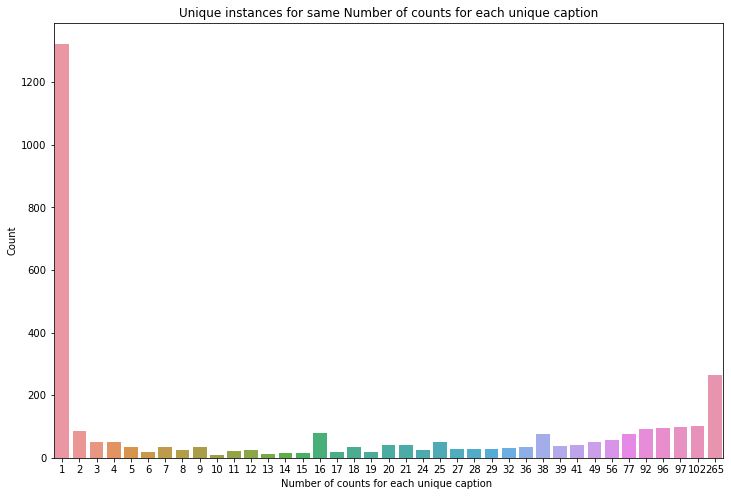

In [182]:
import seaborn as sns
df_counts_unique = df2.Caption_count.value_counts().reset_index()

plt.figure(figsize=(12,8))
ax = sns.barplot(x='index', y= 'Caption_count', data = df_counts_unique)
plt.xlabel("Number of counts for each unique caption ")
plt.ylabel("Count")
plt.title("Unique instances for same Number of counts of unique caption")
plt.show()

# Creating train test Dataset

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Making separate df for rows having (>1 & < 6) caption count
ovsmpl_df = df2[(df2.Caption_count < 6) & (df2.Caption_count > 1)]
resampled = resample(ovsmpl_df, n_samples = int(0.2*ovsmpl_df.shape[0]), 
                     replace=False, random_state=42)

# Making separate df for rows having (==1) caption count
ovsmpl_df_count1 = df2[df2.Caption_count == 1]
resampled_count1 = resample(ovsmpl_df_count1, n_samples = int(0.2*ovsmpl_df_count1.shape[0]),
                            replace=False, random_state=43)

df3 = df2.drop(ovsmpl_df.index, axis=0)
df3 = df3.drop(ovsmpl_df_count1.index, axis=0)

train, test = train_test_split(df3, stratify = df3['Caption'].values, test_size=0.2, random_state=42)

test = test.append(resampled)
test = test.append(resampled_count1)
test = test.reset_index(drop=True)

ovsmpl_df = ovsmpl_df.drop(resampled.index, axis=0)
ovsmpl_df_count1 = ovsmpl_df_count1.drop(resampled_count1.index, axis=0)

train = train.append(ovsmpl_df)
train = train.append(ovsmpl_df_count1)

In [208]:
print(f'Train shape: {train.shape}\nTest shape:  {test.shape}') 

Train shape: (2567, 5)
Test shape:  (641, 5)
